# lab 3: basic optimization trying to do the inference using only ha

In [1]:
from contra_qa.text_generation.boolean2_S_and import boolean2
from contra_qa.text_processing.functions import simple_pre_process_text_df
from contra_qa.plots.functions  import plot_histogram_from_labels, plot_confusion_matrix, simple_step_plot

from contra_qa.train_functions.RNNConfig import RNNConfig
import numpy as np
import torch
import torch.nn as nn
from torchtext import data

import pandas as pd
import  matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

% matplotlib inline

In [2]:
boolean2()
df2 = pd.read_csv("data/boolean2_train.csv")

In [3]:
df2.tail()

,sentence1,sentence2,and_A,and_B,label
9995,Alison is important and Dennis is poor,Dennis is not poor,Alison is important,Dennis is poor,1
9996,Debbie is proud and Kayla is kind,Debbie is not proud,Debbie is proud,Kayla is kind,1
9997,Tom is mushy and Erin is important,Erin is not important,Tom is mushy,Erin is important,1
9998,Roy is careful and Derrick is shy,Derrick is not shy,Roy is careful,Derrick is shy,1
9999,Kristina is calm and Emily is obedient,Greg is rich,Kristina is calm,Emily is obedient,0


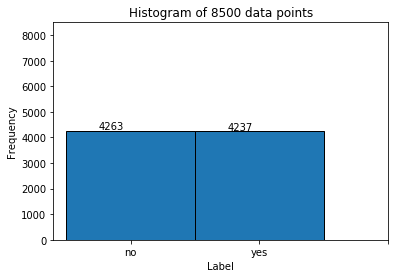

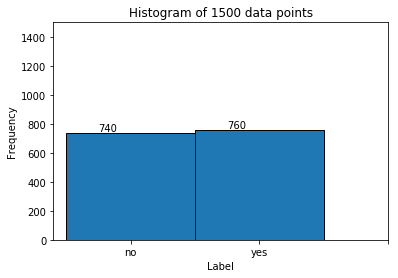

In [4]:
df2train = df2.iloc[:8500]
df2valid = df2.iloc[8500:]
plot_histogram_from_labels(df2train.label.values, ["no", "yes"], "test.png") 
plot_histogram_from_labels(df2valid.label.values, ["no", "yes"], "test.png")

In [5]:
simple_pre_process_text_df(df2, "sentence1")
simple_pre_process_text_df(df2, "sentence2")
simple_pre_process_text_df(df2, "and_A")
simple_pre_process_text_df(df2, "and_B")

df2["text"] = df2["sentence1"] + ", " + df2["sentence2"]
df2_little = df2[["text", "label"]]

df2_little.head()

,text,label
0,"claudia is famous and crystal is clever, cryst...",1
1,"annie is better and marion is gifted, marion i...",1
2,"clara is happy and jonathan is hallowed, clara...",0
3,"michele is kind and june is shy, june is not kind",0
4,"holly is gentle and alfred is polite, florence...",0


In [6]:
train_data_path = "data/boolean_2_train_lab.csv"
df2_little.to_csv(train_data_path, header=False, index=False)
TEXT = data.Field()
LABEL = data.LabelField(tensor_type=torch.FloatTensor)
train = data.TabularDataset(path=train_data_path,
                            format="csv",
                            fields=[('text', TEXT), ('label', LABEL)])
TEXT.build_vocab(train, max_size=25000)
LABEL.build_vocab(train)

In [7]:
print('len(TEXT.vocab):', len(TEXT.vocab))
print('len(LABEL.vocab):', len(LABEL.vocab))

len(TEXT.vocab): 753
len(LABEL.vocab): 2


In [8]:
def finde_size(list_):
    return np.max(list(map(lambda x: len(x.split(" ")), list_)))

In [9]:
def str_list2tensor(list_):
    list_i = []
    max_size = finde_size(list_)
    for line in list_:
        line = line.split(" ")
        size = len(line) 
        tail = max_size - size
        line += [TEXT.pad_token] * tail
        new_line = [TEXT.vocab.stoi[word] for word in line]
        list_i.append(new_line)
    return torch.tensor(list_i, dtype=torch.long, device=device)

In [10]:
s1_t = str_list2tensor(list(df2train.sentence1.values))
s2_t = str_list2tensor(list(df2train.sentence2.values))
ha_t = str_list2tensor(list(df2train.and_A.values))
hb_t = str_list2tensor(list(df2train.and_B.values))

y_t = torch.tensor(list(df2train.label.values),
                   dtype=torch.long,
                   device=device)

In [11]:
from torch.utils.data import TensorDataset

train_dataset = TensorDataset(s1_t, s2_t, ha_t, hb_t, y_t)
valid_dataset = TensorDataset(s1_t, s2_t, ha_t, hb_t, y_t)
test_dataset = TensorDataset(s1_t, s2_t, ha_t, hb_t, y_t)

In [12]:
from torch.utils.data import DataLoader

class DataHolder():
    """
    Class to store all data using the GentleLoader.

    :param config: hyper params configuration
    :type config: LRConfig or DFNConfig
    :param train_dataset: dataset of training data
    :type train_dataset: torch.utils.data.dataset.TensorDataset
    :param test_dataset: dataset of test data
    :type test_dataset: torch.utils.data.dataset.TensorDataset
    :param valid_dataset: dataset of valid data
    :type valid_dataset: torch.utils.data.dataset.TensorDataset
    :param batch_size: batch size for training
    :type test_batch: batch size for the testing data
    :param test_batch: int
    """
    def __init__(self,
                 config,
                 train_dataset,
                 valid_dataset,
                 test_dataset,
                 test_batch=1000):
        batch_size = config.batch_size
        self.train_loader = DataLoader(dataset=train_dataset,
                                         batch_size=batch_size,
                                         shuffle=True)
        self.valid_loader = DataLoader(dataset=valid_dataset,
                                         batch_size=batch_size,
                                         shuffle=True)
        self.test_loader = DataLoader(dataset=test_dataset,
                                        batch_size=test_batch,
                                        shuffle=True)

In [13]:
config = RNNConfig(vocab_size=len(TEXT.vocab),
                   output_dim=len(LABEL.vocab),
                   embedding_dim=10,
                   rnn_dim=10,
                   learning_rate=0.02)

test_data = DataHolder(config,
                    train_dataset,
                    valid_dataset,
                    test_dataset)

In [14]:
class AddRNN(nn.Module):
    def __init__(self, config):
        super(AddRNN, self).__init__()
        self.vocab_size = config.vocab_size
        self.embedding_dim = config.embedding_dim
        self.output_dim = config.output_dim
        self.rnn_dim = config.rnn_dim
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.rnn = nn.GRU(self.embedding_dim, self.rnn_dim) 
        self.fc_out = nn.Linear(self.rnn_dim, self.output_dim)
        self.fc_A = nn.Linear(self.rnn_dim, self.rnn_dim)
        self.fc_B = nn.Linear(self.rnn_dim, self.rnn_dim)
        
    def encode(self, x, hidden=None):
        if hidden is None:
            hidden = torch.zeros((1, x.shape[1], self.rnn_dim), device=device)
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded, hidden)
        hidden = hidden.squeeze(0)
        return hidden
    
    def forward(self, s1, s2):
        """
        Apply the model to the input x
        :param x: indices of the sentence
        :type x: torch.Tensor(shape=[sent len, batch size]
                              dtype=torch.int64)
        """
        e1 = self.encode(s1)
        hahat = self.fc_A(e1)
        hahat = hahat.view((1, hahat.shape[0], hahat.shape[1]))
        

        e2 = self.encode(s2, hahat)
        out = self.fc_out(e2)
        return out

    def predict(self, s1, s2):
        out = self.forward(s1, s2)
        softmax = nn.Softmax(dim=1)
        out = softmax(out)
        indices = torch.argmax(out, 1)
        return indices

In [15]:
def train_in_epoch(model, iterator, optimizer, criterion):
    """
    Train the model using all the data from the iterator
    Negative is a flag to train the model to maximize the
    loss function
    :param model: RNN classification model
    :type model: RNN
    :param iterator: data iterator
    :type iterator: data.BucketIterator
    :param optimizer: torch optimizer
    :type optimizer: optim.SGD, etc.
    :param criterion: loss criterion
    :type criterion: nn.CrossEntropyLoss
    :param negative: control param
    :type negative: boolean
    :return: mean loss, mean accuracy
    :rtype: float, float
    """

    epoch_loss = []
    epoch_acc = []

    model.train()

    for batch in iterator:

        optimizer.zero_grad()
        s1, s2, ha, hb, label = batch
        s1 = s1.view(s1.shape[1], s1.shape[0])
        s2 = s2.view(s2.shape[1], s2.shape[0])
        logits = model(s1, s2)
        loss = criterion(logits, label)
        pred = model.predict(s1, s2)
        acc = np.mean(torch.eq(pred, label).numpy())
        epoch_loss.append(loss.item())
        epoch_acc.append(acc)

        loss.backward()
        optimizer.step()

    return epoch_loss, epoch_acc

In [16]:
config = RNNConfig(vocab_size=len(TEXT.vocab),
                   output_dim=len(LABEL.vocab),
                   embedding_dim=10,
                   rnn_dim=20,
                   learning_rate=0.247,
                   momentum=0.0,
                   epochs=25)
model = AddRNN(config)
iterator = test_data.train_loader
optimizer = torch.optim.SGD(model.parameters(),
                            lr=config.learning_rate,
                            momentum=config.momentum)
criterion = nn.CrossEntropyLoss()
loss, acc = train_in_epoch(model,
                           iterator,
                           optimizer,
                           criterion)

assert len(loss) == len(acc)

## Vizualizing the train loss and acc during epochs

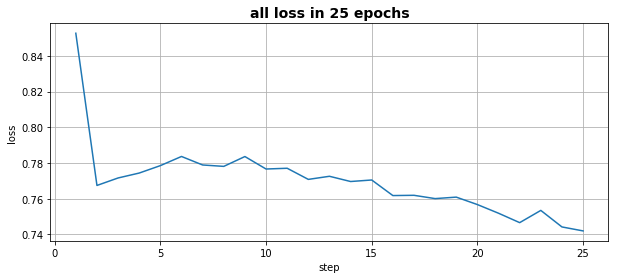

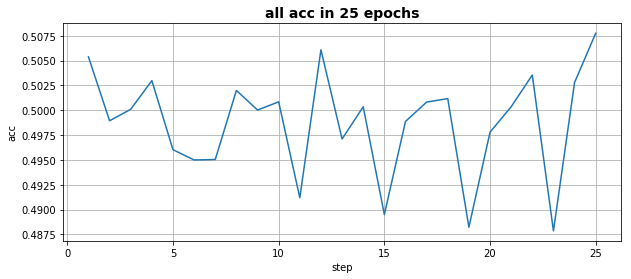

In [17]:
config = RNNConfig(vocab_size=len(TEXT.vocab),
                   output_dim=len(LABEL.vocab),
                   embedding_dim=200,
                   rnn_dim=200,
                   learning_rate=0.747,
                   momentum=0.0,
                   epochs=25)


model = AddRNN(config)
iterator = test_data.train_loader
optimizer = torch.optim.SGD(model.parameters(),
                            lr=config.learning_rate,
                            momentum=config.momentum)

    
criterion = nn.CrossEntropyLoss()

all_loss = []
all_acc = []

epochs = config.epochs

for i in range(epochs):
    loss, acc = train_in_epoch(model,
                               iterator,
                               optimizer,
                               criterion)

    all_loss.append(np.mean(loss))
    all_acc.append(np.mean(acc))
    
simple_step_plot([all_loss],
                 yname="loss",
                 path="loss.png",
                 title="all loss in {} epochs".format(epochs),
                 figsize=(10, 4))

simple_step_plot([all_acc],
                 yname="acc",
                 path="acc.png",
                 title="all acc in {} epochs".format(epochs),
                 figsize=(10, 4))